In [1]:
import json 
# sort tweets into Washington vs. Massachusetts
tweets_WA = []
tweets_MA = []
f = 'ECE219_tweet_data/tweets_#superbowl.txt'
for line in open(f, 'r'):
    tweet = json.loads(line)
    loc = tweet['tweet']['user']['location']
    if " WA" in loc or ("Washington" in loc and "DC" not in loc and "D.C." not in loc):
        tweets_WA.append(tweet['tweet']['text'])
    elif " MA" in loc or "Massachusetts" in loc:
        tweets_MA.append(tweet['tweet']['text'])

In [2]:
print(len(tweets_WA)) 
print(len(tweets_MA)) 

12548
13687


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
        

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meganwilliams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/meganwilliams/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/meganwilliams/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# Convert tweets to TF-IDF
import numpy as np
import random
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation

def build_vectorizer(min_df):
    wnl = nltk.wordnet.WordNetLemmatizer()
    stop_words_skt = text.ENGLISH_STOP_WORDS
    stop_words_en = stopwords.words('english')
    combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
    
    analyzer = CountVectorizer().build_analyzer()

    def lemmatize_sent(list_word):
        # Text input is string, returns array of lowercased strings(words).
        return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
                for word, tag in pos_tag(list_word)]
            
    def stem_rmv_punc(doc):
        return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

    def penn2morphy(penntag):
        """ Converts Penn Treebank tags to WordNet. """
        morphy_tag = {'NN':'n', 'JJ':'a',
                'VB':'v', 'RB':'r'}
        try:
            return morphy_tag[penntag[:2]]
        except:
            return 'n'

    return CountVectorizer(min_df=min_df, analyzer=stem_rmv_punc, stop_words='english')

def vectorize_data(data1, data2, min_df=3):
    train_dataset = data1 + data2
    Bin_Target_Train = np.zeros(len(train_dataset))
    Bin_Target_Train[0:len(data1)] = 1
    c = zip(train_dataset, Bin_Target_Train)
    random.shuffle(c)
    train_dataset, Bin_Target_Train = zip(*c)

    count_vect = build_vectorizer(min_df=min_df)

    X_train_counts = count_vect.fit_transform(train_dataset)
    #X_test_counts = count_vect.transform(test_dataset.data)

    # Report the shape of the TF-IDF matrices of the train and test subsets respectively**
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    #X_test_tfidf = tfidf_transformer.transform(X_test_counts)

    return X_train_tfidf, Bin_Target_Train

X_train_tfidf, Bin_Target_Train = vectorize_data(tweets_WA, tweets_MA)

In [5]:
print(X_train_tfidf.shape)

(26235, 5448)


In [6]:
# Dimension Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd

def LSI_(X_train_tfidf):

    svd = TruncatedSVD(n_components=50, random_state=0)

    U, Sigma, VT = randomized_svd(X_train_tfidf, 
                              n_components=50,
                              n_iter=5,
                              random_state=None)

    # print U.shape, Sigma.shape, VT.shape
    X_train_r = svd.fit_transform(X_train_tfidf)
    #X_test_r = svd.transform(X_test_tfidf)
    Err_LSI = 0
    A = np.dot(np.dot(U,np.diag(Sigma)),VT)
    Err_LSI = np.sum(np.array(X_train_tfidf - A)**2)
    return X_train_r, Err_LSI

X, _  = LSI_(X_train_tfidf)

In [9]:
#  Helper Functions
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
import itertools
import matplotlib.pyplot as plt

def print_metrics(y_true, y_predict, options= "binary" ):
    print('Accuracy: %f' % accuracy_score(y_true, y_predict))
    print('Precision: %f'% precision_score(y_true, y_predict,average = options))
    print('Recall: %f'% recall_score(y_true, y_predict,average = options))
    print('F1-score: %f' % f1_score(y_true, y_predict,average = options))
    

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, lw=2, label='area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=15)
    ax.set_ylabel('True Positive Rate', fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(15)
        
def fit_predict_and_plot_roc1(sv_instance, test_data, test_label):
 
    if hasattr(sv_instance, 'decision_function'):
        prob_score = sv_instance.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = sv_instance.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:, 1])

    plot_roc(fpr, tpr)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

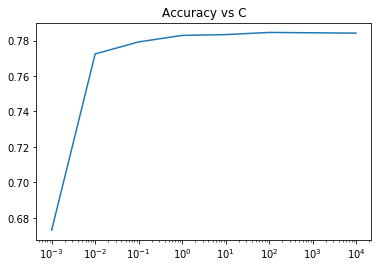

Best C: 100.000000
Accuracy: 0.784563
Precision: 0.902126
Recall: 0.616535
Normalized confusion matrix
[[0.93372178 0.06627822]
 [0.37809752 0.62190248]]


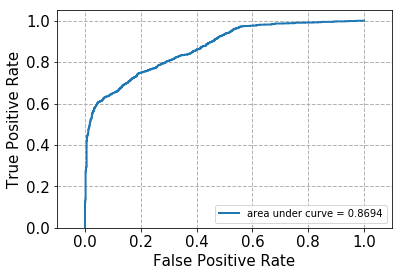

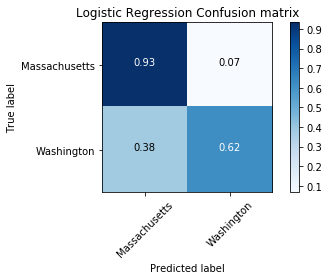

In [11]:
# Logistic Classifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, f1_score
from sklearn.model_selection import KFold, train_test_split


def logistic_classifier(X, y):
    c_values = 10.0 ** np.array(range(-3,5)) # 10^-3 to 10^3
    accuracies = []
    precisions = []
    recalls = []
    
    for c in c_values:
        kf = KFold(n_splits=10, shuffle = True)
        acc_total = 0
        recall_total = 0
        prec_total = 0
    
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = LogisticRegression(C=c).fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            acc_total += accuracy_score(y_test, y_predict)
            recall_total += recall_score(y_test, y_predict)
            prec_total += precision_score(y_test, y_predict)
        acc_total = acc_total / 10.0
        recall_total = recall_total / 10.0
        prec_total = prec_total / 10.0
        accuracies.append(acc_total)
        precisions.append(prec_total)
        recalls.append(recall_total)
    plt.figure()
    plt.semilogx(c_values,  accuracies)
    plt.title('Accuracy vs C')
    plt.show() 
    best_c = np.argmax(accuracies)
    print("Best C: %f" % c_values[best_c])
    print('Accuracy: %f' % accuracies[best_c])
    print('Precision: %f' % precisions[best_c])
    print('Recall: %f' % recalls[best_c])
    
    # Plot ROC and Confusion matrix with best C
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
    clf = LogisticRegression(C=c_values[best_c]).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #print_metrics(y_test, y_pred)
    fit_predict_and_plot_roc1(clf, X_test, y_test)
    cnf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    plt.figure()
    class_names = ['Massachusetts', 'Washington']
    plot_confusion_matrix(cnf_matrix, classes=class_names,  normalize=True,
                                  title='Logistic Regression Confusion matrix')
    plt.show()
    
    
y = np.array(Bin_Target_Train)
logistic_classifier(X, y)

In [ ]:
# SVM

In [ ]:
# Naive Bayes